<a href="https://colab.research.google.com/github/YaoYinYing/low-n-protein-engineering/blob/master/Low_N_engineering_pre-evotuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#@title Install softwares
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import urllib3
import gzip


try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

JAX_UNIREP_REPO='https://github.com/ElArkk/jax-unirep.git'
DOWNLOAD_PFAM_SCRIPT='https://raw.githubusercontent.com/xqding/PEVAE_Paper/master/pfam_msa/script/download_MSA.py'
ENTREZ_URL='ftp://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect//install-edirect.sh'

ROOT_DIR='/gdrive/MyDrive/low-n-data'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_BLAST=f"{RES_DIR}/MSA/blast"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'

CONDA_PATH='/opt/miniconda'

# if not already installed
total = 5
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [ROOT_DIR,
              TMP_DIR,FLAG_DIR,WEIGHTS_DIR,SCRIPTS_DIR,
              JOBS_DIR,
              RES_DIR,RES_DIR_MSA,RES_DIR_BLAST,RES_DIR_FITNESS,RES_DIR_SEQ_OUT,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(1)

  # jax-unirep
  try:
    from jax_unirep import evotune
  except:
    os.system(f'pip install git+{JAX_UNIREP_REPO}')
    os.system('pip install biopython')
    os.system('pip install awscli')
    os.system('pip install optuna')
    os.system('pip install seaborn')
    os.system('pip install python-Levenshtein')
    os.system('apt install expect -y')
    os.system(f'wget -qnc {ENTREZ_URL} -P .')
  pbar.update(1)


  # weights
  os.system(f'if [ ! -f {FLAG_DIR}/WEIGHT_READY ]; then cd {WEIGHTS_DIR}; for i in 1900_weights/ 256_weights/ 64_weights/ 1900_weights_random/ 256_weights_random/ 64_weights_random/ evotuned/unirep/ evotuned/random_init/; do echo $i; aws s3 sync --no-sign-request s3://unirep-public/$i $i; done;touch {pathlib.Path(FLAG_DIR).resolve()}/WEIGHT_READY;fi')
  pbar.update(1)

  !chmod +x ./install-edirect.sh && expect -c 'spawn ./install-edirect.sh; expect { "[y/N]" {send "y\n" }}'
  pbar.update(1)
  

  if f"{pathlib.Path('/root/edirect').resolve()}" not in os.environ['PATH']:
    os.environ['PATH'] += f":{pathlib.Path('/root/edirect').resolve()}"
  pbar.update(1)




  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

spawn ./install-edirect.sh

Entrez Direct has been successfully downloaded and installed.

In order to complete the configuration process, please execute the following:

  echo "export PATH=\${PATH}:" >> $HOME/.bashrc

or manually edit the PATH variable assignment in your .bashrc file.

Would you like to do that automatically now? [y/N]


In [ ]:
#@title Goto GPU part if all data were collected.

In [ ]:
#@title PFam sucked when fetching full sequence archive. 
'''
def download_pfam(pfam_id):
  
  #https://github.com/xqding/PEVAE_Paper/blob/master/pfam_msa/script/download_MSA.py
  
  print(f"Downloading the full multiple sequence alignment for Pfam: {pfam_id} ......")
  http = urllib3.PoolManager()
  r = http.request('GET', f'http://pfam.xfam.org/family/{pfam_id}/alignment/long/gzipped')
  data = gzip.decompress(r.data)
  data = data.decode()

  with open(f"{RES_DIR_MSA}/{pfam_id}_full.fasta", 'w') as file_handle:
    file_handle.write(data)
    
  print(f"MSA_downloaded: {pfam_id}")


pfam_id='PF00067'
download_pfam(pfam_id)
os.system(f'cd {RES_DIR_MSA};tar jcvf {pfam_id}.stockholm.tar.bz2 {pfam_id}_full.txt' )
'''

In [ ]:
#@title Function: Fetch InterPro data in full sequence fasta
# standard library modules
import json, ssl
from urllib import request
from urllib.error import HTTPError
from time import sleep

def download_interpro(interpro_id):
    BASE_URL = f"https://www.ebi.ac.uk:443/interpro/api/protein/UniProt/entry/InterPro/{interpro_id}/?page_size=200&extra_fields=sequence"
    
    HEADER_SEPARATOR = "|"
    LINE_LENGTH = 80

    with open(f'{RES_DIR_MSA}/{interpro_id}.fasta', 'w') as fasta_file_handle:
        # disable SSL verification to avoid config issues
        context = ssl._create_unverified_context()
        
        next = BASE_URL
        last_page = False
        
        attempts = 0
        while next:
            try:
                req = request.Request(next, headers={"Accept": "application/json"})
                res = request.urlopen(req, context=context)
                # If the API times out due a long running query
                if res.status == 408:
                    # wait just over a minute
                    print(f'wasting life for res.status: {res.status}')
                    sleep(7)
                    # then continue this loop with the same URL
                    continue
                elif res.status == 204:
                    # no data so leave loop
                    break
                payload = json.loads(res.read().decode())
                next = payload["next"]
                attempts = 0
                if not next:
                    last_page = True
            except HTTPError as e:
                if e.code == 408:
                    print(f'wasting life for e.code: {e.code}')
                    sleep(31)
                    continue
                else:
                    # If there is a different HTTP error, it wil re-try 3 times before failing
                    if attempts < 3000:
                        attempts += 1
                        print(f'wasting life for attempts: {attempts}')
                        sleep(13)
                        continue
                    else:
                        print("LAST URL: " + next)
                        raise e

            for i, item in enumerate(payload["results"]):
                
                if ("entries" in item):
                    for entry in item["entries"]:
                        for locations in entry["entry_protein_locations"]:
                            for fragment in locations["fragments"]:
                                start = fragment["start"]
                                end = fragment["end"]
                                fasta_file_handle.write(">" + item["metadata"]["accession"] + HEADER_SEPARATOR
                                                        + entry["accession"] + HEADER_SEPARATOR
                                                        + str(start) + "..." + str(end) + HEADER_SEPARATOR
                                                        + item["metadata"]["name"] + "\n")
                                seq = item["extra_fields"]["sequence"]
                                fastaSeqFragments = [seq[0 + i:LINE_LENGTH + i] for i in range(0, len(seq), LINE_LENGTH)]
                                for fastaSeqFragment in fastaSeqFragments:
                                    fasta_file_handle.write(fastaSeqFragment + "\n")
                else:
                    fasta_file_handle.write(
                        ">" + item["metadata"]["accession"] + HEADER_SEPARATOR + item["metadata"]["name"] + "\n")
                    seq = item["extra_fields"]["sequence"]
                    fastaSeqFragments = [seq[0 + i:LINE_LENGTH + i] for i in range(0, len(seq), LINE_LENGTH)]
                    for fastaSeqFragment in fastaSeqFragments:
                        fasta_file_handle.write(fastaSeqFragment + "\n")

                # Don't overload the server, give it time before asking for more
            if next:
                sleep(2)


In [ ]:
#@title Download sequences from InterPro (skip this part! Upload fasta file instead)
# download your sequences anywhere else! Its a timekiller!

download_interpro("IPR001128") 

'''
for i in [
          'IPR017972',
          'IPR002403',
          #'IPR001128', skipped
          'IPR036396']:
  download_interpro(i)
'''

In [ ]:

target_fasta = f'{JOBS_DIR}/890.fasta'
target_fasta=pathlib.Path(target_fasta).resolve()
job_name=target_fasta.name

In [ ]:
#@title Function: Run BLAST for homologs searching
from Bio.Blast import NCBIWWW
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import Entrez

def low_n_blast(input_fasta):
  input_fasta=pathlib.Path(input_fasta).resolve()
  record = SeqIO.read(input_fasta, format=str(input_fasta.suffix).replace(".",""))

  # blast configs
  jobname=input_fasta.name
  blast_program=  ["blastp"]*3
  dbs=            ['swissprot','refseq_protein','nr']
  max_hit_num=    [50000]*3
  print(f'Doing online BLAST for {jobname}')
  for p,db,h in zip(blast_program,dbs,max_hit_num):
    
    print("-"*45)
    print(f'program:      {p}')
    print(f'db:           {db}')
    print(f'max_hit_num:  {h}')
    result_handle = NCBIWWW.qblast(p, db, record.seq,hitlist_size=h)
    with open(f"{RES_DIR_REPORT}/blast_{jobname}_program-{p}_db-{db}_hitnum-{h}.xml", "w") as out_handle:
      out_handle.write(result_handle.read())
    result_handle.close()
    print("-"*45)
  print(f'Online BLAST searching: Done.)

In [ ]:
#@title Function: Read accessions from BLAST result
import glob
import re
import xml.etree.ElementTree as ET

def get_blast_accession():
  blast_reports=glob.glob(f'{RES_DIR_REPORT}/blast_*.xml')
  #blast_reports=glob.glob(f'*.xml')
  acs=[]
  for report in blast_reports:
    #print(f'Reading {report} ... ')
    report_=pathlib.Path(report).resolve()

    with open(report_) as result_handle:
      res_=result_handle.read()
      #db=re.findall(r'<BlastOutput_db>([\w]+)</BlastOutput_db>',res_)[0]
      acs_=re.findall(r'<Hit_accession>([\w]+)</Hit_accession>',res_)
      print(f'Find {len(acs_)} in {report} . ')
    acs +=acs_
  acs=list(set(acs))
  print(f"Total number of accession fetched: {len(acs)}")
  return acs

In [ ]:
#@title Function: Download sequences from NCBI
import os
from Bio import SeqIO
from Bio import Entrez
import traceback
from time import sleep
import random

Entrez.email = email  # Always tell NCBI who you are
def get_ncbi_seq( accession):
  filename = f"{RES_DIR_BLAST}/{accession}.fasta"
  is_downloaded=False
  retry_count=6
  while not is_downloaded:
    try:
      if not os.path.isfile(filename):
        retry_count -=1
        # Downloading...
        sleep(random.randint(1,3))
        net_handle = Entrez.efetch(
              db='protein', id=accession, rettype="fasta", retmode="text"
          )
        out_handle = open(filename, "w")
        out_handle.write(net_handle.read())
        out_handle.close()
        net_handle.close()
        sleep(random.randint(1,2))
      else:
        #downloaded already
        return None
      is_downloaded=True
    except Exception as e:
      print(f'{accession}: {e}')
      if "Bad Request" in str(e):
        # no result, stop the thread.
        return None
      elif "Too Many Requests" in str(e):
        # have a rest and take another try!
        sleep(random.randint(1,3))
    finally:
      if retry_count ==0:
        # max retry reached, abored.
        print(f'max retry reached: {accession}')
        return None 
      sleep(.001)
      
def minibatches(inputs_data, batch_size):
    # fix data losing with minibatches
    for start_idx in range(0, len(inputs_data) - batch_size + batch_size, batch_size):
        if len(inputs_data[start_idx:])>batch_size:
            excerpt = slice(start_idx, start_idx + batch_size)
            #print("yielding data len: %s" % len(inputs_data[excerpt]))
            yield inputs_data[excerpt]
        else:
            #print("yielding final data len: %s" % len(inputs_data[start_idx:]))
            yield inputs_data[start_idx:]

def save_acs_list(acs,size=1000):
  count=0
  for sub_batch_acs in minibatches(acs, size):
    with open(f'{RES_DIR_REPORT}/blast-accessions-{count}-{len(sub_batch_acs)}.txt','w') as accession_list_handle:
      accession_list_handle.write('\n'.join(sub_batch_acs))
      count+=1

In [ ]:
#@title Do BLAST seaching against non-redundant protein sequence database.
#@markdown This is still a Timekiller! That's why we need Gdrive to save everything!


#@markdown **DOWNLOAD W/ CPU SESSION ONLY!**
low_n_blast(target_fasta)

Doing online BLAST for 890.fasta
---------------------------------------------
program:      blastp
db:           swissprot
max_hit_num:  50000
---------------------------------------------
Doing online BLAST for 890.fasta
---------------------------------------------
program:      blastp
db:           refseq_protein
max_hit_num:  50000
---------------------------------------------
Doing online BLAST for 890.fasta
---------------------------------------------
program:      blastp
db:           nr
max_hit_num:  50000
---------------------------------------------


In [ ]:
#@title Fetching Sequences in BLAST results

#@markdown **DOWNLOAD W/ CPU SESSION ONLY!**
acs=get_blast_accession()
email="yaoyy.hi@gmail.com"
from concurrent.futures import ThreadPoolExecutor
import time
executor = ThreadPoolExecutor(max_workers=5)
with tqdm.notebook.tqdm(total=len(acs), bar_format=TQDM_BAR_FORMAT) as pbar:
  for result in executor.map(get_ncbi_seq, acs):
    pbar.update(1)

os.system(f'cat {RES_DIR_BLAST}/*.fasta > ../blast-homologs_{job_name}.fasta')


In [ ]:
#@title Archive BLAST results xml and download a backup
os.system(f'cd {RES_DIR_REPORT};tar jvcf blast-res_{job_name}_.tar.bz2 blast_*.xml; mv blast-res_{job_name}_.tar.bz2 ../../')

from google.colab import files
files.download(f'blast-res_{job_name}_.tar.bz2')

In [ ]:
#@title Skip this shit
accession_excluded=[x for x in open(f'{RES_DIR_REPORT}/blast-exclusive_id.txt','r').read().split('\n')]
save_acs_list([x for x in acs if x not in accession_excluded],size=100)

In [ ]:
os.system(f'tar xjcv MSAs_{job_name}_blast.tar.bz2 {RES_DIR_MSA} --exclude IPR001128.fasta')
files.download(f'MSAs_{job_name}_blast.tar.bz2')


In [ ]:
#@title Sequence Mutator


def generate_mutant(wt_fasta,mutations,sep=''):

  def mutate(sequence, mutations, list_or_string='string'):
  # WTF? Why not Mutable sequence?
    if (list_or_string == 'string'):
        mutations = mutations.split(sep)
    mut_sequence = list(sequence)
    for mut in mutations:
        curr_res = mut[0]
        mut_res = mut[-1]
        mut_pos = mut[1:-1]
        mut_sequence[int(mut_pos)-1] = mut_res
    return ''.join(mut_sequence)
    
  print( str(type(mutations)))
  if str(type(mutations))=="<class 'list'>":
    mutations_string='-'.join(mutations)
    mutations_list=mutations
  elif str(type(mutations))=="<class 'str'>":
    mutations_string=mutations
    mutations_list=mutations.split(sep)
  else:
    raise TypeError(f'type(mutations)={ str(type(mutations))}')
  print(mutations_list)
  in_path=pathlib.Path(wt_fasta).resolve()
  out_path=pathlib.Path(f'{in_path.stem}_{mutations_string}.{in_path.suffix}')
  fasta_seqs = SeqIO.parse(open(in_path),'fasta')
  out_file = open(out_path, "w")
  for fasta in fasta_seqs:
    name, sequence = fasta.id, str(fasta.seq)
    out_file.write('>' + mutations_string + '_' + name + '\n')
    mut_seq = mutate(sequence,mutations_string, 'string')
    out_file.write(mut_seq)

  out_file.close()

In [ ]:
generate_mutant("./890.fasta","I46L_L109F_F113L_E286A_C343Y",sep='_')

In [ ]:
#@title GPU PART!
'''
! cp -r /gdrive/MyDrive/low-n-data/* .


ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
'''

target_fasta = f'{JOBS_DIR}/890.fasta'
target_fasta=pathlib.Path(target_fasta).resolve()
job_name=target_fasta.name


In [ ]:
#@title Fetching P450 data(210 MB for InterPro ?Did we fetch all the data?)

P450_FASTA_URL="https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/eb41191248895405aa47da6e70458d529fbe836a/data/IPR001128.fasta.tar.bz2"
os.system(f'wget -qnc {P450_FASTA_URL} -P {RES_DIR_MSA}')
os.system(f'cd {RES_DIR_MSA}; tar xjvf IPR001128.fasta.tar.bz2; mv IPR001128.fasta.tar.bz2 ..')


P450_TARGET_URL='https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/eb41191248895405aa47da6e70458d529fbe836a/data/890.fasta'
os.system(f'wget -qnc {P450_TARGET_URL} -P {JOBS_DIR}')

P450_BLAST_RES_URL='https://github.com/YaoYinYing/low-n-protein-engineering/raw/master/data/blast_res_890.fasta.tar.bz2'
os.system(f'wget -qnc {P450_BLAST_RES_URL} -P {RES_DIR_MSA} && cd {RES_DIR_MSA} &&  tar xvjf blast_res_890.fasta.tar.bz2')


P450_EXPERI_DATA_URL='https://github.com/YaoYinYing/low-n-protein-engineering/raw/master/data/P450_experi_data_encoded.csv'
os.system(f'wget -qnc {P450_EXPERI_DATA_URL} -P {RES_DIR_FITNESS}' )

0

In [ ]:
#@title Generate Inputs for Evotuning eUniRep for P450 family
# https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/pre-evotuning/generate_evotune_inputs_2MS2.ipynb

from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt


 # Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    # Yinying edited here bcs pfam provides stockholm formated file. 
    # PFam use stockholm while InterPro use fasta
    
    fasta_seqs = SeqIO.parse(open( name ), name.suffix.replace(".",''))
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open(f'{RES_DIR_SEQ_OUT}/{name}_out.fasta', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped due to length >', k, ':', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of invalid sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of valid sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')

In [ ]:
#@title Read protein family and clean the data for evotuning.
import glob


# input FASTA files:
in_fastas = [pathlib.Path(x).resolve() for x in glob.glob(f"{RES_DIR_MSA}/*") if x.endswith('.fasta')]

# put sequences into a pandas dataframes
sequences_df = pd.concat([pd.DataFrame(read_fasta(in_fastas[i]), columns = ['name', 'sequence']) for i in range(len(in_fastas))], axis=0).reset_index().drop('index', axis=1)

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
# the number here is the AA length we want - set to 350
clean_seqs_df = clean(sequences_df, 600)

# save clean sequences as a .fasta.txt file
write_fasta('P450_all_sequences_clean', clean_seqs_df)

Total number of input sequences: 501743
Total number of sequences dropped due to length > 600 : 27667
Total number of sequences remaining: 474076
Total number of invalid sequences dropped: 6277
Total number of valid sequences remaining: 467799
Total sequences remaining after duplicate removal 382060


In [ ]:
#@title Check P450 sequences
sequences_df.head()

,name,sequence
0,A0A009JPS9|IPR001128|197...300|Cytochrome,MFIAMDPPKHDVQRQAVQDVVAPKNLKELEGLIRLRVQEVLDQLPT...
1,A0A010PZX0|IPR001128|227...483|Ent-kaurene,MSLSWSGWPATLEPQQSALGLLFVVLSLTLAYISIPGRHDHLPYIN...
2,A0A010PZY6|IPR001128|296...495|Prostacyclin,MADSSSAAATAVATLLERFSSTSSVKLIASAVALVVTVLMVIDKFV...
3,A0A010Q013|IPR001128|153...528|Cytochrome,MAPISQLLPPVASLSGVGLLALGSIALLYIISRVFLSIPYPKDIPL...
4,A0A010Q0Z9|IPR001128|248...438|Uncharacterized,MLREILYAFTGLALLAYAADFFYSTGDDPNEPVRIRSRFPLIGHVL...


In [ ]:
#@title load target sequence

targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])

NP_001289636.1
MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE


Mean Levenstein distance: 383.4109354551641
Median Levenstein distance: 383.4109354551641
Min Levenstein distance: 0
Max Levenstein distance: 477


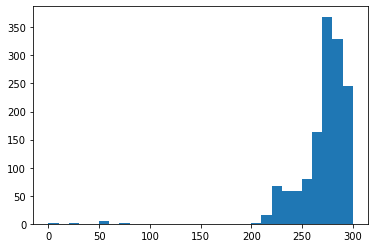

In [ ]:
#@title calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df, 30, (0,300))

Out of domain validation set size: 38206
Mean Levenstein distance: 388.084018217034
Median Levenstein distance: 388.084018217034
Min Levenstein distance: 226
Max Levenstein distance: 475


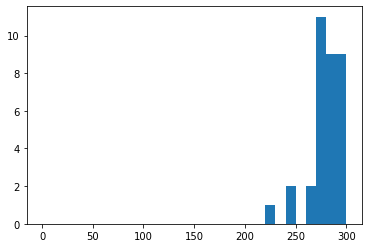

Training set size: 343854
Mean Levenstein distance: 382.89170403717856
Median Levenstein distance: 382.89170403717856
Min Levenstein distance: 0
Max Levenstein distance: 477


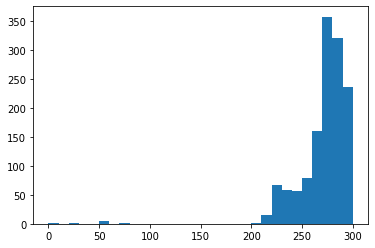

In [ ]:
#@title partition into the training and 2 validation sets:

clean_seqs_df_copy = clean_seqs_df.copy()
out_domain_val_set = clean_seqs_df_copy.sample(frac=0.1, weights=distances**4, random_state=17)
remainder_df = clean_seqs_df_copy.drop(out_domain_val_set.index)
#train_set = remainder_df.sample(frac=0.889, random_state=17)
#in_domain_val_set = remainder_df.drop(train_set.index)

# set check sizes and levenstein distances
print('Out of domain validation set size:', len(out_domain_val_set))
out_dom_distances = lev_dist(targets[0][1], out_domain_val_set.reset_index().drop('index', axis=1), 30, (0,300))

#print('In domain validation set size:', len(in_domain_val_set))

print('Training set size:', len(remainder_df))
training_distances = lev_dist(targets[0][1], remainder_df.reset_index().drop('index', axis=1), 30, (0,300))

In [ ]:
#@title save to fasta file formats:

write_fasta(f'{job_name}_train_set', remainder_df.reset_index().drop('index', axis=1))
write_fasta(f'{job_name}_out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
#write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))